#### 1. Data load 및 Data 형태 확인


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy import stats 
import warnings 
warnings.filterwarnings('ignore')

# Pima Indians Diabetes Dataset (Kaggle 대표 분류 데이터셋)

url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

# 데이터 구조 확인
print("="*50)
print("1. 데이터 로드 및 형태 확인")
print("="*50)
print(f"데이터 차원: {df.shape}")
print("\n데이터 샘플:")
print(df.head())
print("\n컬럼 정보:")
print(df.info())
print("\n기술 통계량:")
print(df.describe())
print("\n결측치 확인 (원본):")
print(df.isnull().sum())

1. 데이터 로드 및 형태 확인
데이터 차원: (768, 9)

데이터 샘플:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

컬럼 정보:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 no

#### 2. NaN 값 처리 및 EDA



2. NaN 값 처리 및 EDA


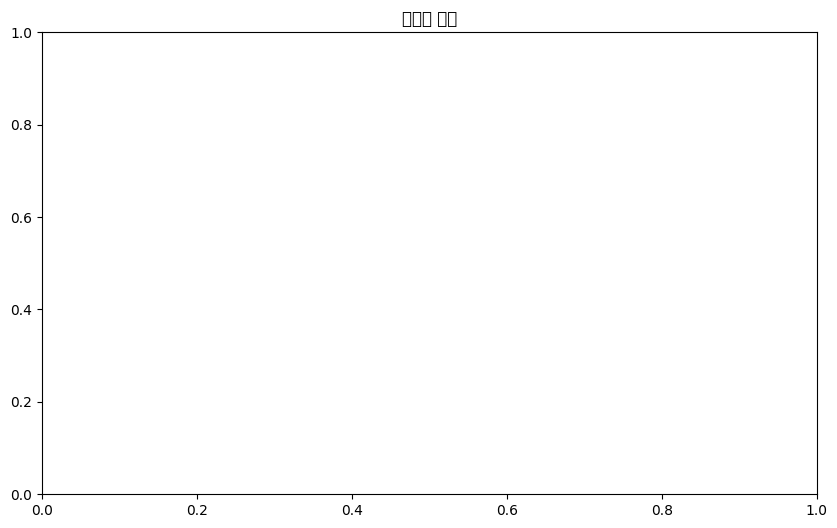

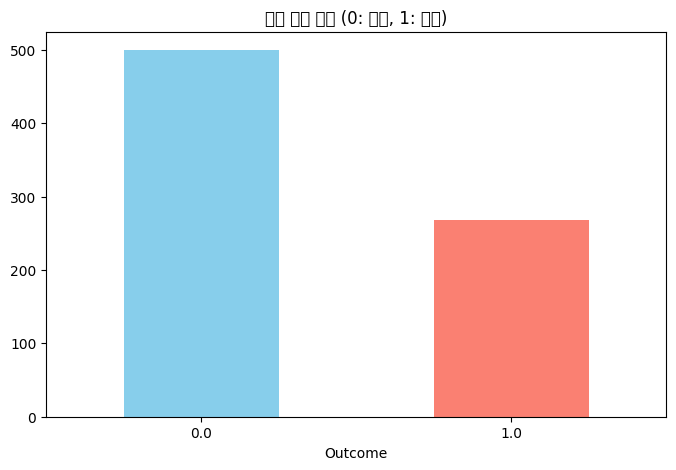

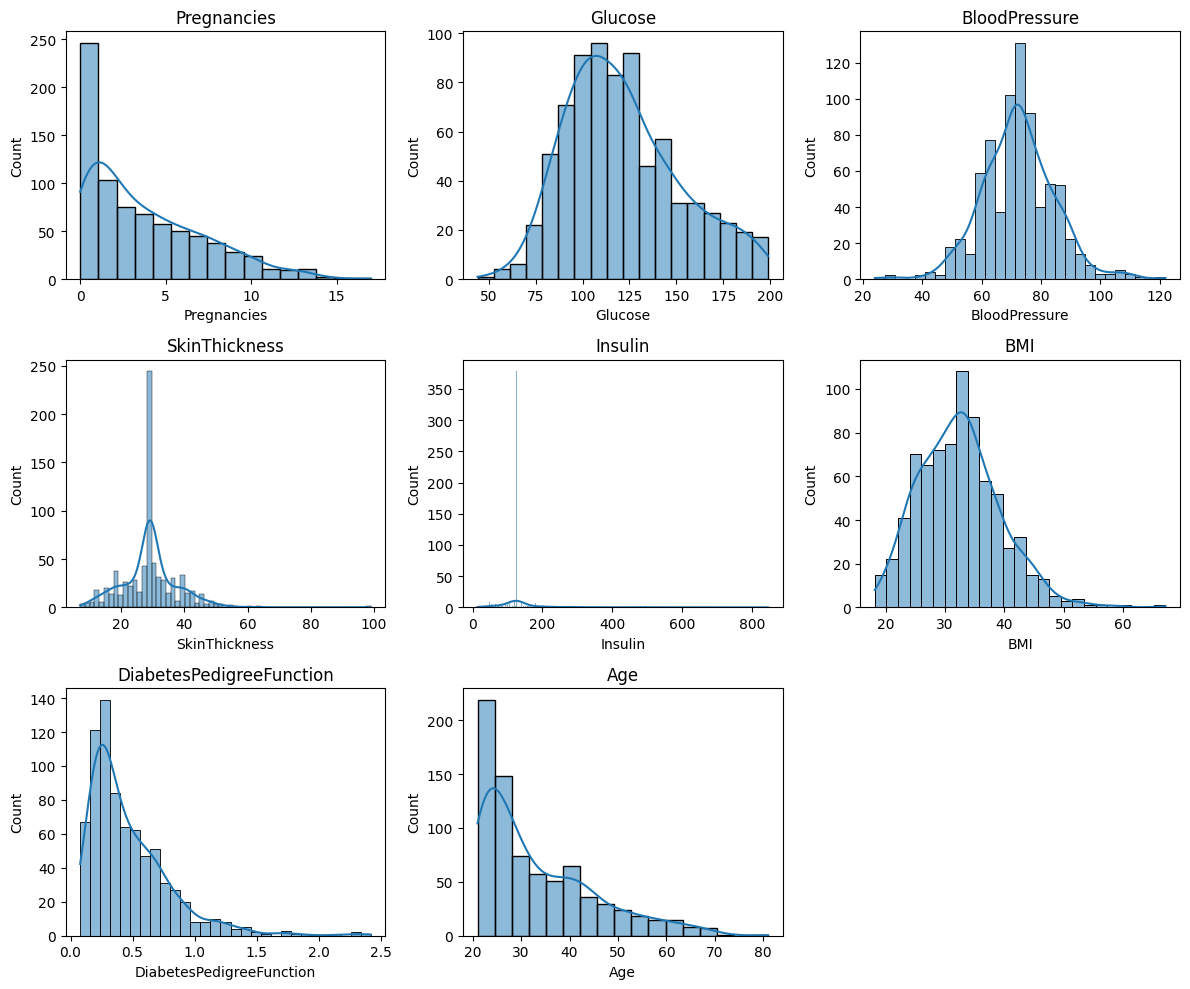

In [4]:
print("\n" + "="*50)
print("2. NaN 값 처리 및 EDA")
print("="*50)
# 0값을 NaN으로 변환 (의학적 데이터에서 0은 불가능한 값)
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_columns] = df[zero_columns].replace(0, np.nan)

# 결측치 시각화
plt.figure(figsize=(10,6))
# msno.bar(df, color=(0.2, 0.4, 0.6))  # missingno 라이브러리 대신 직접 구현
plt.title('결측치 분포')
plt.show()

from sklearn.impute import SimpleImputer 
imputer = SimpleImputer(strategy='median') 
df_imputed = pd.DataFrame(imputer.fit_transform(df),columns=df.columns) 

# EDA: 타겟 변수 분포
plt.figure(figsize=(8,5))
df_imputed['Outcome'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('타겟 변수 분포 (0: 건강, 1: 당뇨)')
plt.xticks(rotation=0)
plt.show()

# EDA: 수치형 변수 
import seaborn as sns
plt.figure(figsize=(12,10))
for i, col in enumerate(df_imputed.columns[:-1]):
    plt.subplot(3,3,i+1)
    sns.histplot(df_imputed[col], kde=True)  # seaborn 대신 matplotlib으로 구현
    plt.title(col)
plt.tight_layout()
plt.show()


#### 3. Preprocessing

In [13]:
print("\n" + "="*50)
print("3. 데이터 전처리")
print("="*50)

# 연령을 범주형 변수로 변환 (LabelEncoder 예시)
df_imputed['AgeGroup'] = pd.cut(df_imputed['Age'], 
                            bins=[20, 30, 40, 50, 100], 
                            labels=['20s', '30s', '40s', '50+'])

# 특성과 타겟 분리
X = df_imputed.drop('Outcome', axis=1)
y = df_imputed['Outcome']

# 수치형/범주형 특성 분류
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['AgeGroup']

# 파이프라인 구축
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# 데이터 분할
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)


3. 데이터 전처리


#### 4. Model Selection and fit

In [14]:
print("\n" + "="*50)
print("4. 모델 학습")
print("="*50)

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb 

models = {
    'Logist Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
}

# cross-val
from sklearn.model_selection import cross_val_score 
results = {} 
for name,model in models.items(): 
    pipeline = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('classifier',model)
    ])
    scores = cross_val_score(pipeline,X_train,y_train,cv=5,scoring='accuracy')
    results[name] = {
        'model': pipeline, 
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores)
    }
    print(f"{name}: 평균 정확도 {np.mean(scores):.4f} (±{np.std(scores):.4f})")



4. 모델 학습
Logist Regression: 평균 정확도 0.7786 (±0.0279)
Random Forest: 평균 정확도 0.7606 (±0.0341)
XGBoost: 평균 정확도 0.7362 (±0.0286)


#### 5. Prediction


5. 예측 및 평가

최종 모델: Logist Regression
              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80       100
         1.0       0.64      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154



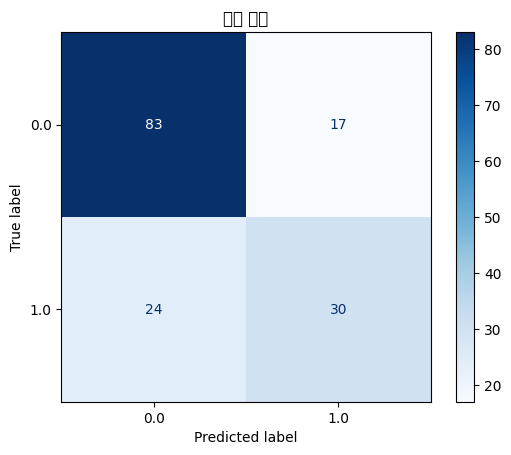

In [15]:
print("\n" + "="*50)
print("5. 예측 및 평가")
print("="*50)

# best model select
best_model_name = max(results, key=lambda k:results[k]['mean_accuracy'])
best_model = results[best_model_name]['model']
best_model.fit(X_train,y_train) 

# 성능 평가
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
y_pred = best_model.predict(X_test) 

print(f"\n최종 모델: {best_model_name}")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title('혼동 행렬')
plt.show()

#### 6. Feature engineering

In [18]:
from sklearn.model_selection import GridSearchCV
print("\n" + "="*50)
print("6. 성능 개선")
print("="*50)

# XGB params
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__max_depth': [3, 5],
    'classifier__subsample': [0.8, 0.9]
}

grid_search = GridSearchCV(
    estimator=results['XGBoost']['model'],
    param_grid=param_grid, 
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose = 1
)

grid_search.fit(X_train, y_train)

print(f"최적 파라미터: {grid_search.best_params_}")
print(f"최고 정확도: {grid_search.best_score_:.4f}")
import joblib
joblib.dump(grid_search.best_estimator_, 'best_diabetes_model.pkl')
print("\n모델이 'best_diabetes_model.pkl'로 저장되었습니다.")


6. 성능 개선
Fitting 5 folds for each of 16 candidates, totalling 80 fits
최적 파라미터: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}
최고 정확도: 0.7655

모델이 'best_diabetes_model.pkl'로 저장되었습니다.
